<a href="https://colab.research.google.com/github/stellagerantoni/learning-time-series-counterfactuals/blob/main/multivariate_pendigits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! git clone https://github.com/stellagerantoni/learning-time-series-counterfactuals
%cd learning-time-series-counterfactuals/

Cloning into 'learning-time-series-counterfactuals'...
remote: Enumerating objects: 336, done.
remote: Counting objects: 100% (198/198), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 336 (delta 136), reused 168 (delta 120), pack-reused 138
Receiving objects: 100% (336/336), 5.52 MiB | 11.27 MiB/s, done.
Resolving deltas: 100% (205/205), done.
/content/learning-time-series-counterfactuals


In [2]:

!pip install -q wildboar
!pip install -q scikit-learn
!pip install -q stumpy
!pip install -q fastdtw
!pip install aeon[all_extras]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.1/169.1 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.0/39.0 MB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 24.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.4/160.4 kB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.1/812.1 kB 68.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 46.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 88.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.4/153.4 kB 18.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import logging
import os
import warnings
from argparse import ArgumentParser
from aeon.datasets import load_classification

from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from scipy.spatial import distance_matrix
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KDTree, KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from wildboar.datasets import load_dataset
from wildboar.ensemble import ShapeletForestClassifier
from wildboar.explain.counterfactual import counterfactuals

from _composite import ModifiedLatentCF
%cd src
from _vanilla import LatentCF
from help_functions import (ResultWriter, conditional_pad, evaluate,
                            find_best_lr, plot_graphs,
                            reset_seeds, time_series_normalize,
                            time_series_revert, upsample_minority,
                            validity_score)
from keras_models import *

/content/learning-time-series-counterfactuals/src


In [4]:
os.environ['TF_DETERMINISTIC_OPS'] = '1'
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
RANDOM_STATE = 39

## **FUNCTIONS**

In [5]:
def load_dataset(dataset):
  X, y, meta_data = load_classification(dataset)
  if dataset == 'Heartbeat':
    pos = 'normal'
    neg = 'abnormal'
    X = X.transpose(0,2,1)
  if dataset == 'SelfRegulationSCP1':
    pos = 'positivity'
    neg = 'negativity'
    X = X.transpose(0,2,1)
  if dataset == 'Cricket':
    return X,y,meta_data
  if dataset == 'SpokenArabicDigits':
    return X,y,meta_data
  if dataset == 'PenDigits':
    return X,y,meta_data

  print(" Shape of X = ", X.shape)
  print(" Shape of y = ", y.shape)
  print(" Meta data = ", meta_data)
  # Convert positive and negative labels to 1 and 0
  pos_label, neg_label = 1, 0
  if pos != pos_label:
      y[y==pos] = pos_label # convert/normalize positive label to 1
  if neg != neg_label:
      y[y==neg] = neg_label # convert negative label to 0

  y = y.astype(int)
  print(f"\n X[:1] = \n{X[:1]}")
  return X,y,pos_label, neg_label

In [ ]:
from sklearn.utils import resample, shuffle
def upsample_minority(X, y, pos_label=1, neg_label=0, random_state=39):
    # Get counts
    ones = pd.value_counts(y_train)['1']
    twos = pd.value_counts(y_train)['2']
    threes = pd.value_counts(y_train)['3']
    fours = pd.value_counts(y_train)['4']
    fives = pd.value_counts(y_train)['5']
    sixes = pd.value_counts(y_train)['6']
    sevens = pd.value_counts(y_train)['7']
    eights = pd.value_counts(y_train)['8']
    nines = pd.value_counts(y_train)['9']
    print(f'before upsampling: ones = {ones}, twos = {twos}, trees = {threes}, fours = {fours},fives = {fives},\n sixes = {sixes}, sevens = {sevens}, eights = {eights}, nines = {nines}' )

    # Divide by class
    num_count.append(ones)
    num_count.append(twos)
    num_count.append(threes)
    num_count.append(fours)
    num_count.append(fives)
    num_count.append(sixes)
    num_count.append(sevens)
    num_count.append(eights)
    num_count.append(nines)

    max_count = 0

    for i in num_count:
      if i > max_count:
        max_count = i
      elif i = max_count:
        X = X
    for i in range(9):
      X_to_resample = X[y == i]
      y_for_resampling = y[y == i]
      X_to_resample = resample(y_for_resampling, replace=True, n_samples=max_count, random_state=random_state)

      X_concat = np.concatenate([X_pos, X_neg_over], axis=0)
      y_concat = np.array(
            [pos_label for i in range(pos_counts)]
            + [neg_label for j in range(pos_counts)]
        )
    # Shuffle the index after up-sampling
    X_concat, y_concat = shuffle(X_concat, y_concat, random_state=random_state)

    return X_concat, y_concat

In [21]:
unique_classes, class_counts = np.unique(y_train, return_counts=True)
print(class_counts)
unique_classes

[914 914 915 844 915 844 845 914 844 844]


array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype='<U1')

In [28]:
from sklearn.utils import resample, shuffle
def upsample_minority_multivariate(X, y, random_state=39):
    unique_classes, class_counts = np.unique(y, return_counts=True)
    max_count = max(class_counts)

    X_resampled_list = []
    y_resampled_list = []

    for cls in unique_classes:
        X_cls = X[y == cls]
        y_cls = y[y == cls]

        # Resample the current class data to match the max count
        X_cls_resampled, y_cls_resampled = resample(X_cls, y_cls,
                                                    replace=True, # sample with replacement (upsample)
                                                    n_samples=max_count, # match the number in majority class
                                                    random_state=random_state) # reproducible results

        X_resampled_list.append(X_cls_resampled)
        y_resampled_list.append(y_cls_resampled)

    # Vertically stack the resampled data for each class
    X_resampled = np.vstack(X_resampled_list)
    y_resampled = np.hstack(y_resampled_list)
    X_concat, y_concat = shuffle(X_resampled, y_resampled, random_state=random_state)

    return X_resampled, y_resampled


In [30]:
X_train,y_train = upsample_minority_multivariate(X_train,y_train)
unique_classes, class_counts = np.unique(y_train, return_counts=True)
print(class_counts)

[915 915 915 915 915 915 915 915 915 915]


y = [0. 1.]


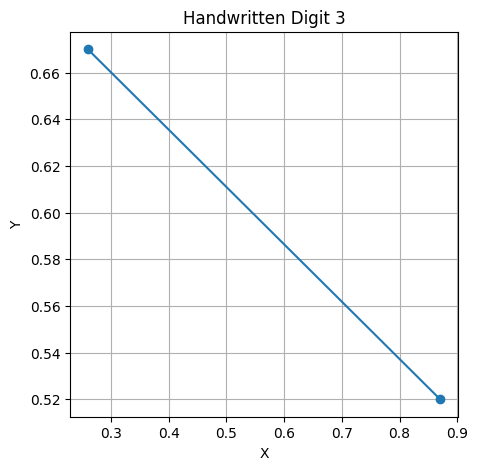

In [365]:
idx = 0
print(f'y = {y_train[idx]}')
x_coords = X_train[idx, 0]
y_coords = X_train[idx,1]
plt.figure(figsize=(5, 5))  # Adjust the figure size as needed
plt.plot(x_coords, y_coords, marker='o', linestyle='-')
plt.title("Handwritten Digit 3")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)

# Display the plot
plt.show()

In [32]:
X[1]

array([[  0.,  27.,  42.,  29.,  15.,  37.,  69., 100.],
       [ 89., 100.,  75.,  45.,  15.,   0.,   2.,   6.]])

In [9]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np


def normalize_multivariate(data, n_timesteps, n_features, scaler=None):

    # Then reshape data to have timesteps as rows for normalization
    data_reshaped = data.reshape(-1, n_features)

    if scaler is None:
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaler.fit(data_reshaped)

    normalized = scaler.transform(data_reshaped)

    # Return data reshaped
    data = normalized.reshape(-1, n_timesteps, n_features)
    return data, scaler

def conditional_pad_multivariate(X):
    num_timesteps = X.shape[1]

    if num_timesteps % 4 != 0:
        next_num = (int(num_timesteps / 4) + 1) * 4
        padding_size = next_num - num_timesteps
        X_padded = np.pad(
            X, pad_width=((0, 0), (0, padding_size), (0, 0))
        )

        return X_padded, padding_size

    return X, 0



# **ACTUALL CODE**
datasets available : 'Heartbeat', 'SelfRegulationSCP1'

In [373]:
X,y,data_information = load_dataset('PenDigits')
print(f'shape of X = {X.shape}')
print(f'shape of y = {y.shape}')
print(f'data imformation = {data_information}')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
print(f'shape of X train = {X_train.shape}')
print(f'shape of y train = {y_train.shape}')

shape of X = (10992, 2, 8)
shape of y = (10992,)
data imformation = {'problemname': 'pendigits', 'timestamps': False, 'missing': False, 'univariate': False, 'equallength': True, 'classlabel': True, 'targetlabel': False, 'class_values': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']}
shape of X train = (8793, 2, 8)
shape of y train = (8793,)


In [375]:
unique_classes, class_counts = np.unique(y_train, return_counts=True)
print(class_counts)

[914 914 915 844 915 844 845 914 844 844]


In [376]:
# Upsample the minority class

X_train,y_train = upsample_minority_multivariate(X_train,y_train)
unique_classes, class_counts = np.unique(y_train, return_counts=True)
print(class_counts)

[915 915 915 915 915 915 915 915 915 915]


In [369]:
X_train = X_train.transpose (0,2,1)
X_train.shape

(9150, 8, 2)

In [351]:
n_training,n_timesteps, n_features= X_train.shape

X_train_processed, trained_scaler =  normalize_multivariate(data=X_train, n_timesteps=n_timesteps, n_features = n_features)
X_test_processed, _ =  normalize_multivariate(data=X_test, n_timesteps=n_timesteps, scaler=trained_scaler, n_features = n_features)

X_train_processed_padded, padding_size = conditional_pad_multivariate(X_train_processed) # add extra padding zeros if n_timesteps cannot be divided by 4, required for 1dCNN autoencoder structure
X_test_processed_padded, _ = conditional_pad_multivariate(X_test_processed)

n_timesteps_padded = X_train_processed_padded.shape[1]
print(f"Data pre-processed, original #timesteps={n_timesteps}, padded #timesteps={n_timesteps_padded}.")

#check the processing (0,1) min should be min 0 and max should be max 1
print(f"\nmin value = {np.min(X_train)}, max value = {np.max(X_train)}")
print(f"min value normalized = {np.min(X_train_processed)}, max value normalized= {np.max(X_train_processed)}")

#check that padding paddes the right dimention
print(f"\nX_train.shape = {X_train.shape}" )
print(f"X_train_processed_padded.shape = {X_train_processed_padded.shape}")



Data pre-processed, original #timesteps=8, padded #timesteps=8.

min value = 0.0, max value = 100.0
min value normalized = 0.0, max value normalized= 1.0

X_train.shape = (9150, 8, 2)
X_train_processed_padded.shape = (9150, 8, 2)


In [370]:
X_train_processed_padded.shape

(9150, 8, 2)

In [371]:
y_train.shape

(9150,)

y = 8


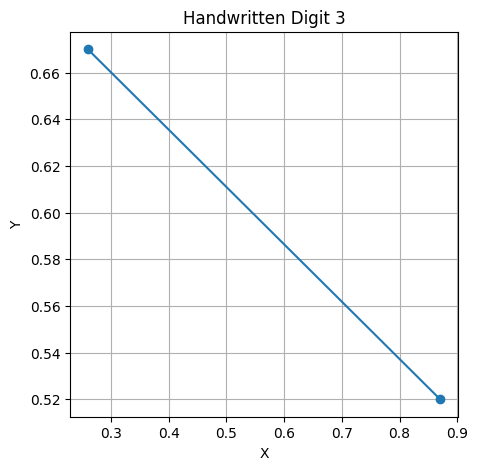

In [380]:
idx = 0
print(f'y = {y_train[idx]}')
x_coords = X_train[idx, 0]
y_coords = X_train[idx,1]
plt.figure(figsize=(5, 5))  # Adjust the figure size as needed
plt.plot(x_coords, y_coords, marker='o', linestyle='-')
plt.title("Handwritten Digit 3")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)

# Display the plot
plt.show()

In [379]:
y_train_zeroes = y_train[y_train == '0']
X_train_zeroes = X_train_processed_padded[y_train == '0' ]
y_train_eights = y_train [y_train == '8']
X_train_eights = X_train_processed_padded [y_train =='8']
y_train = np.concatenate([y_train_zeroes, y_train_eights])
X_train = np.concatenate([X_train_zeroes, X_train_eights])
y_test_zeroes = y_test[y_test == '0']
X_test_zeroes = X_test_processed_padded[y_test == '0' ]
y_test_eights = y_test [y_test == '8']
X_test_eights = X_test_processed_padded [y_test =='8']
y_test = np.concatenate([y_test_zeroes, y_test_eights])
X_test = np.concatenate([X_test_zeroes, X_test_eights])
X_train, y_train = shuffle(X_train, y_train,random_state=RANDOM_STATE)
X_test,y_test = shuffle(X_test,y_test,random_state = RANDOM_STATE)

In [360]:
for i in range(y_train.shape[0]):
  if y_train[i] == '8':
    y_train[i]=1
  else:
    y_train [i]=0
for i in range(y_test.shape[0]):
  if y_test[i] == '8':
    y_test[i]=1
  else:
    y_test[i]=0
y_train = y_train.astype(int)
y_test = y_test.astype(int)
y_train_classes = y_train
y_test_classes = y_test
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, len(np.unique(y_train)))
y_test = to_categorical(y_test, len(np.unique(y_test)))

In [361]:
y_train_classes

array([1, 1, 0, ..., 1, 0, 1])

In [195]:
y_train.shape

(1830, 2)

In [362]:
from keras.regularizers import l2
def Classifier(
    n_timesteps, n_features, n_conv_layers=1, add_dense_layer=True, n_output=2
):
    # https://keras.io/examples/timeseries/timeseries_classification_from_scratch/

    input_shape = (n_timesteps, n_features)

    inputs = keras.Input(shape=input_shape, dtype="float32")


    if add_dense_layer:
        x = keras.layers.Dense(128)(inputs)
    else:
        x = inputs

    for i in range(n_conv_layers):
        x = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.ReLU()(x)

    x = keras.layers.MaxPooling1D(pool_size=2, padding="same")(x)
    x = keras.layers.Flatten()(x)

    if n_output >= 2:
        outputs = keras.layers.Dense(n_output, activation="softmax")(x)
    else:
        outputs = keras.layers.Dense(1, activation="sigmoid")(x)

    classifier = keras.models.Model(inputs=inputs, outputs=outputs)

    return classifier
def LSTMFCNClassifier(n_timesteps, n_features, n_output, n_LSTM_cells=8, regularization_rate = 0.001,input_format_stf=True):
    # https://github.com/titu1994/LSTM-FCN/blob/master/hyperparameter_search.py
    if input_format_stf:
      input_shape = (n_timesteps, n_features)
    else:
      input_shape = (n_features, n_timesteps)
    inputs = keras.Input(shape=input_shape, dtype="float32")

    x = keras.layers.LSTM(units=n_LSTM_cells, kernel_regularizer=l2(regularization_rate))(inputs)
    x = keras.layers.Dropout(rate=0.6)(x)

    y = keras.layers.Permute((2, 1))(inputs)
    y = keras.layers.Conv1D(64, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=l2(regularization_rate))(y)
    y = keras.layers.BatchNormalization()(y)
    y = keras.layers.ReLU()(y)

    y = keras.layers.Conv1D(128, 2, padding="same", kernel_initializer="he_uniform", kernel_regularizer=l2(regularization_rate))(y)
    y = keras.layers.BatchNormalization()(y)
    y = keras.layers.ReLU()(y)

    y = keras.layers.Conv1D(64, 2, padding="same", kernel_initializer="he_uniform", kernel_regularizer=l2(regularization_rate))(y)
    y = keras.layers.BatchNormalization()(y)
    y = keras.layers.ReLU()(y)

    y = keras.layers.GlobalAveragePooling1D()(y)

    x = keras.layers.concatenate([x, y])

    outputs = keras.layers.Dense(n_output, activation="softmax", kernel_regularizer=l2(regularization_rate))(x)

    classifier = keras.models.Model(inputs=inputs, outputs=outputs)

    return classifier

def ClassifierLSTM(n_timesteps, n_features, extra_lstm_layer=True, n_output=1, input_format_stf = True):
    # Define the model structure - only LSTM layers
    # https://www.kaggle.com/szaitseff/classification-of-time-series-with-lstm-rnn

    if input_format_stf:
      input_shape = (n_timesteps, n_features)
    else:
      input_shape = (n_features, n_timesteps)
    inputs = keras.Input(shape=input_shape, dtype="float32")

    if extra_lstm_layer:
        x = keras.layers.LSTM(64, activation="tanh", return_sequences=True)(
            inputs
        )  # set return_sequences true to feed next LSTM layer
    else:
        x = keras.layers.LSTM(32, activation="tanh", return_sequences=False)(
            inputs
        )  # set return_sequences false to feed dense layer directly
    x = keras.layers.BatchNormalization()(x)
    # x = keras.layers.LSTM(32, activation='tanh', return_sequences=True)(x)
    # x = keras.layers.BatchNormalization()(x)
    if extra_lstm_layer:
        x = keras.layers.LSTM(16, activation="tanh", return_sequences=False)(x)
        x = keras.layers.BatchNormalization()(x)

    if n_output >= 2:
        outputs = keras.layers.Dense(n_output, activation="softmax")(x)
    else:
        outputs = keras.layers.Dense(1, activation="sigmoid")(x)

    classifier2 = keras.Model(inputs, outputs)

    return classifier2

def Classifier_FCN(input_shape, nb_classes):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=128, kernel_size=8, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.Activation(activation="relu")(conv1)

    conv2 = keras.layers.Conv1D(filters=256, kernel_size=5, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.Activation("relu")(conv2)

    conv3 = keras.layers.Conv1D(128, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.Activation("relu")(conv3)

    gap_layer = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(nb_classes, activation="softmax")(gap_layer)

    model = keras.models.Model(inputs=input_layer, outputs=output_layer)

    return model

def EnhancedClassifier(
    n_timesteps,
    n_features,
    n_conv_layers=2,
    add_dense_layer=True,
    n_output=1,
    input_format_stf=True # if True, input is (series, features, timesteps); otherwise (series, timesteps, features)
):
    # Choose input shape based on the flag
    if input_format_stf:
      input_shape = (n_features, n_timesteps)
    else:
      input_shape = (n_timesteps, n_features)

    inputs = keras.Input(shape=input_shape, dtype="float32")

    if add_dense_layer:
        x = keras.layers.TimeDistributed(keras.layers.Dense(128))(x)

    for _ in range(n_conv_layers):
        x = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same", activation='relu')(x)
        x = keras.layers.BatchNormalization()(x)

    x = keras.layers.MaxPooling1D(pool_size=2, padding="same")(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(64, activation="relu")(x) # Additional dense layer for complexity

    if n_output >= 2:
        outputs = keras.layers.Dense(n_output, activation="softmax")(x)
    else:
        outputs = keras.layers.Dense(1, activation="sigmoid")(x)

    classifier = keras.models.Model(inputs=inputs, outputs=outputs)

    return classifier

In [220]:
X_train_processed_padded = X_train_processed_padded.transpose(0,2,1)
X_test_processed_padded = X_test_processed_padded.transpose(0,2,1)

In [306]:
X_train.shape

(1830, 8, 2)

In [307]:
X_test.shape

(440, 8, 2)

In [88]:
y_train

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [363]:
INPUT_FORMAT_STF = True
if INPUT_FORMAT_STF == False:
  X_train = X_train.transpose(0,2,1)
  X_test= X_test.transpose(0,2,1)

n_lstmcells = 60
# ## 2. LatentCF models
# reset seeds for numpy, tensorflow, python random package and python environment seed
reset_seeds()
###############################################
# ## 2.0 LSTM-FCN classifier
###############################################
# ### LSTM-FCN classifier
LSTMFCNclassifier = LSTMFCNClassifier(
    n_timesteps_padded, n_features, n_output=2, n_LSTM_cells=n_lstmcells,input_format_stf=INPUT_FORMAT_STF
)

optimizer = keras.optimizers.Adam(lr=0.001)
LSTMFCNclassifier.compile(
    optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
)

# Define the early stopping criteria
early_stopping_accuracy = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=60, restore_best_weights=True
)
# Train the model
reset_seeds()
print("Training log for LSTM-FCN classifier:")
classifier_history = LSTMFCNclassifier.fit(
    X_train,
    y_train,
    epochs=150,
    batch_size=12,
    shuffle=True,
    verbose=True,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping_accuracy],
)

y_pred = LSTMFCNclassifier.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
acc = balanced_accuracy_score(y_true=y_test_classes, y_pred=y_pred_classes)
print(f"LSTM-FCN classifier trained, with validation accuracy {acc}.")

confusion_matrix_df = pd.DataFrame(
    confusion_matrix(y_true=y_test_classes, y_pred=y_pred_classes, labels=[1, 0]),
    index=["True:8", "True:0"],
    columns=["Pred:8", "Pred:0"],
)
print(confusion_matrix_df)

if INPUT_FORMAT_STF == False:
  X_train = X_train.transpose(0,2,1)
  X_test = X_test.transpose(0,2,1)

Training log for LSTM-FCN classifier:
Epoch 1/150
153/153 [==============================] - 8s 20ms/step - loss: 0.5776 - accuracy: 0.9754 - val_loss: 1.5016 - val_accuracy: 0.4364
Epoch 2/150
153/153 [==============================] - 3s 17ms/step - loss: 0.3285 - accuracy: 0.9945 - val_loss: 2.3229 - val_accuracy: 0.4568
Epoch 3/150
153/153 [==============================] - 3s 18ms/step - loss: 0.2303 - accuracy: 0.9978 - val_loss: 2.2933 - val_accuracy: 0.4455
Epoch 4/150
153/153 [==============================] - 2s 16ms/step - loss: 0.2014 - accuracy: 0.9902 - val_loss: 2.3293 - val_accuracy: 0.4182
Epoch 5/150
153/153 [==============================] - 2s 11ms/step - loss: 0.1556 - accuracy: 0.9984 - val_loss: 1.7246 - val_accuracy: 0.3023
Epoch 6/150
153/153 [==============================] - 2s 10ms/step - loss: 0.1313 - accuracy: 0.9984 - val_loss: 2.3640 - val_accuracy: 0.3614
Epoch 7/150
153/153 [==============================] - 2s 11ms/step - loss: 0.1127 - accuracy: 0.9

KeyboardInterrupt: ignored

In [334]:
y_train

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [333]:



# ## 2. LatentCF models
# reset seeds for numpy, tensorflow, python random package and python environment seed
reset_seeds()
###############################################
# ## 2.0 classifier
###############################################
# ###  classifier
input_shape = (n_timesteps_padded, n_features)
classifier = Classifier_FCN(
    input_shape, 2
)

optimizer = keras.optimizers.Adam(lr=0.0001)
classifier.compile(
    optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
)

# Define the early stopping criteria
early_stopping_accuracy = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=30, restore_best_weights=True
)
# Train the model
reset_seeds()
print("Training log for LSTM-FCN classifier:")
classifier_history = classifier.fit(
    X_train,
    y_train,
    epochs=150,
    batch_size=32,
    shuffle=True,
    verbose=True,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping_accuracy],
)

y_pred = classifier.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
acc = balanced_accuracy_score(y_true=y_test_classes, y_pred=y_pred_classes)
print(f"LSTM-FCN classifier trained, with validation accuracy {acc}.")

confusion_matrix_df = pd.DataFrame(
    confusion_matrix(y_true=y_test_classes, y_pred=y_pred_classes, labels=[1, 0]),
    index=["True:8", "True:0"],
    columns=["Pred:8", "Pred:0"],
)
print(confusion_matrix_df)


Training log for LSTM-FCN classifier:
Epoch 1/150
58/58 [==============================] - 7s 14ms/step - loss: 0.0662 - accuracy: 0.9842 - val_loss: 0.7070 - val_accuracy: 0.4795
Epoch 2/150
58/58 [==============================] - 1s 9ms/step - loss: 0.0144 - accuracy: 0.9989 - val_loss: 0.7291 - val_accuracy: 0.4659
Epoch 3/150
58/58 [==============================] - 0s 8ms/step - loss: 0.0165 - accuracy: 0.9951 - val_loss: 0.9681 - val_accuracy: 0.4795
Epoch 4/150
58/58 [==============================] - 1s 9ms/step - loss: 0.0083 - accuracy: 0.9995 - val_loss: 0.9059 - val_accuracy: 0.4614
Epoch 5/150
58/58 [==============================] - 0s 8ms/step - loss: 0.0270 - accuracy: 0.9918 - val_loss: 1.2405 - val_accuracy: 0.4568
Epoch 6/150
58/58 [==============================] - 0s 9ms/step - loss: 0.0056 - accuracy: 0.9995 - val_loss: 1.1427 - val_accuracy: 0.3205
Epoch 7/150
58/58 [==============================] - 1s 9ms/step - loss: 0.0034 - accuracy: 0.9995 - val_loss: 1.31

In [309]:

INPUT_FORMAT_STF = True

reset_seeds()
###############################################
# ### LSTM classifier
if INPUT_FORMAT_STF == False:
    X_train = X_train.transpose(0,2,1)
    X_test = X_test.transpose(0,2,1)

classifierLSTM = ClassifierLSTM(n_timesteps_padded, n_features,extra_lstm_layer=True, n_output=2, input_format_stf=INPUT_FORMAT_STF)

optimizer = keras.optimizers.Adam(lr=0.001)
classifierLSTM.compile(
    optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
)

# Define the early stopping criteria
early_stopping_accuracy = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=30, restore_best_weights=True
)
# Train the model
reset_seeds()
print("Training log for LSTM classifier:")
classifier_history = classifierLSTM.fit(
    X_train,
    y_train,
    epochs=150,
    batch_size=42,
    shuffle=True,
    verbose=2,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping_accuracy],
)

y_pred = classifierLSTM.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
acc = balanced_accuracy_score(y_true=y_test_classes, y_pred=y_pred_classes)
print(f"LSTM classifier trained, with validation accuracy {acc}.")

confusion_matrix_df = pd.DataFrame(
    confusion_matrix(y_true=y_test_classes, y_pred=y_pred_classes, labels=[1, 0]),
    index=["True:pos", "True:neg"],
    columns=["Pred:pos", "Pred:neg"],
)
print(f"Confusion matrix: \n{confusion_matrix_df}.")
if INPUT_FORMAT_STF == False:
  X_train= X_train.transpose(0,2,1)
  X_test= X_test.transpose(0,2,1)

Training log for LSTM classifier:
Epoch 1/150
44/44 - 6s - loss: 0.2745 - accuracy: 0.9290 - val_loss: 0.7083 - val_accuracy: 0.3841 - 6s/epoch - 143ms/step
Epoch 2/150
44/44 - 0s - loss: 0.1379 - accuracy: 0.9743 - val_loss: 0.7244 - val_accuracy: 0.4682 - 362ms/epoch - 8ms/step
Epoch 3/150
44/44 - 0s - loss: 0.0887 - accuracy: 0.9863 - val_loss: 0.7458 - val_accuracy: 0.4273 - 376ms/epoch - 9ms/step
Epoch 4/150
44/44 - 0s - loss: 0.0633 - accuracy: 0.9891 - val_loss: 0.7796 - val_accuracy: 0.3841 - 365ms/epoch - 8ms/step
Epoch 5/150
44/44 - 0s - loss: 0.0433 - accuracy: 0.9929 - val_loss: 0.8282 - val_accuracy: 0.3750 - 462ms/epoch - 11ms/step
Epoch 6/150
44/44 - 0s - loss: 0.0356 - accuracy: 0.9978 - val_loss: 0.9110 - val_accuracy: 0.3295 - 487ms/epoch - 11ms/step
Epoch 7/150
44/44 - 0s - loss: 0.0241 - accuracy: 0.9984 - val_loss: 1.0582 - val_accuracy: 0.3364 - 471ms/epoch - 11ms/step
Epoch 8/150
44/44 - 0s - loss: 0.0247 - accuracy: 0.9962 - val_loss: 1.1530 - val_accuracy: 0.25

In [ ]:
def Autoencoder(n_timesteps, n_features):
    # Define encoder and decoder structure
    def Encoder(input):
        x = keras.layers.Conv1D(
            filters=64, kernel_size=3, activation="relu", padding="same"
        )(input)
        x = keras.layers.MaxPool1D(pool_size=2, padding="same")(x)
        x = keras.layers.Conv1D(
            filters=32, kernel_size=3, activation="relu", padding="same"
        )(x)
        x = keras.layers.MaxPool1D(pool_size=2, padding="same")(x)
        return x

    def Decoder(input):
        x = keras.layers.Conv1D(
            filters=32, kernel_size=3, activation="relu", padding="same"
        )(input)
        x = keras.layers.UpSampling1D(size=2)(x)
        x = keras.layers.Conv1D(
            filters=64, kernel_size=3, activation="relu", padding="same"
        )(x)
        # x = keras.layers.Conv1D(filters=64, kernel_size=2, activation="relu")(x)
        x = keras.layers.UpSampling1D(size=2)(x)
        x = keras.layers.Conv1D(
            filters=1, kernel_size=3, activation="linear", padding="same"
        )(x)
        return x

    # Define the AE model
    orig_input = keras.Input(shape=(n_timesteps,n_features))
    autoencoder = keras.Model(inputs=orig_input, outputs=Decoder(Encoder(orig_input)))

    return autoencoder

def AutoencoderLSTM(n_timesteps, n_features):
    # Define encoder and decoder structure
    # structure from medium post: https://towardsdatascience.com/step-by-step-understanding-lstm-autoencoder-layers-ffab055b6352
    def EncoderLSTM(input):
        # x = keras.layers.LSTM(64, activation='relu', return_sequences=True)(input)
        x = keras.layers.LSTM(64, activation="tanh", return_sequences=True)(input)
        # encoded = keras.layers.LSTM(32, activation='relu', return_sequences=False)(x)
        encoded = keras.layers.LSTM(32, activation="tanh", return_sequences=False)(x)
        return encoded

    def DecoderLSTM(encoded):
        x = keras.layers.RepeatVector(n_timesteps)(encoded)
        # x = keras.layers.LSTM(32, activation='relu', return_sequences=True)(x)
        x = keras.layers.LSTM(32, activation="tanh", return_sequences=True)(x)
        # x = keras.layers.LSTM(64, activation='relu', return_sequences=True)(x)
        x = keras.layers.LSTM(64, activation="tanh", return_sequences=True)(x)
        decoded = keras.layers.TimeDistributed(
            keras.layers.Dense(n_features, activation="sigmoid")
        )(x)
        return decoded

    # Define the AE model
    orig_input2 = keras.Input(shape=( n_timesteps,n_features))

    autoencoder2 = keras.Model(
        inputs=orig_input2, outputs=DecoderLSTM(EncoderLSTM(orig_input2))
    )

    return autoencoder2



In [ ]:
X_train_processed_padded.shape

(450, 896, 6)

In [ ]:
reset_seeds()


# ### 1dCNN autoencoder
autoencoder = Autoencoder(n_timesteps_padded, n_features )
optimizer = keras.optimizers.Adam(lr=0.0005)
autoencoder.compile(optimizer=optimizer, loss="mse")

# Define the early stopping criteria
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, restore_best_weights=True)
# Train the model
reset_seeds()
print("Training log for 1dCNN autoencoder:")
autoencoder_history = autoencoder.fit(
    X_train_processed_padded,
    X_train_processed_padded,
    epochs=50,
    batch_size=32,
    shuffle=True,
    verbose=2,
    validation_data=(X_test_processed_padded, X_test_processed_padded),
    callbacks=[early_stopping])

ae_val_loss = np.min(autoencoder_history.history['val_loss'])
print(f"1dCNN autoencoder trained, with validation loss: {ae_val_loss}.")


Training log for 1dCNN autoencoder:
Epoch 1/50
15/15 - 6s - loss: 0.0616 - val_loss: 0.0144 - 6s/epoch - 377ms/step
Epoch 2/50
15/15 - 0s - loss: 0.0046 - val_loss: 0.0013 - 394ms/epoch - 26ms/step
Epoch 3/50
15/15 - 0s - loss: 0.0016 - val_loss: 0.0014 - 339ms/epoch - 23ms/step
Epoch 4/50
15/15 - 0s - loss: 0.0011 - val_loss: 0.0011 - 416ms/epoch - 28ms/step
Epoch 5/50
15/15 - 0s - loss: 8.5874e-04 - val_loss: 6.6260e-04 - 367ms/epoch - 24ms/step
Epoch 6/50
15/15 - 0s - loss: 6.2007e-04 - val_loss: 6.1036e-04 - 390ms/epoch - 26ms/step
Epoch 7/50
15/15 - 0s - loss: 5.8653e-04 - val_loss: 5.9504e-04 - 356ms/epoch - 24ms/step
Epoch 8/50
15/15 - 0s - loss: 5.7407e-04 - val_loss: 5.8598e-04 - 379ms/epoch - 25ms/step
Epoch 9/50
15/15 - 0s - loss: 5.6770e-04 - val_loss: 5.8126e-04 - 396ms/epoch - 26ms/step
Epoch 10/50
15/15 - 0s - loss: 5.6435e-04 - val_loss: 5.7918e-04 - 405ms/epoch - 27ms/step
1dCNN autoencoder trained, with validation loss: 0.0005791778094135225.


In [ ]:
reset_seeds()
# ### 1dCNN autoencoder
autoencoderLSTM = AutoencoderLSTM(n_timesteps_padded, n_features)
optimizer = keras.optimizers.Adam(lr=0.0005)
autoencoderLSTM.compile(optimizer=optimizer, loss="mse")

# Define the early stopping criteria
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, restore_best_weights=True)
# Train the model
reset_seeds()
print("Training log for 1dCNN autoencoder:")
autoencoder_history = autoencoderLSTM.fit(
    X_train_processed_padded,
    X_train_processed_padded,
    epochs=50,
    batch_size=32,
    shuffle=True,
    verbose=2,
    validation_data=(X_test_processed_padded, X_test_processed_padded),
    callbacks=[early_stopping])

ae_val_loss = np.min(autoencoder_history.history['val_loss'])
print(f"1dCNN autoencoder trained, with validation loss: {ae_val_loss}.")

Training log for 1dCNN autoencoder:
Epoch 1/50
15/15 - 14s - loss: 0.0197 - val_loss: 0.0089 - 14s/epoch - 904ms/step
Epoch 2/50
15/15 - 2s - loss: 0.0110 - val_loss: 0.0086 - 2s/epoch - 138ms/step
Epoch 3/50
15/15 - 2s - loss: 0.0103 - val_loss: 0.0081 - 2s/epoch - 118ms/step
Epoch 4/50
15/15 - 2s - loss: 0.0098 - val_loss: 0.0079 - 2s/epoch - 105ms/step
Epoch 5/50
15/15 - 3s - loss: 0.0080 - val_loss: 0.0044 - 3s/epoch - 197ms/step
Epoch 6/50
15/15 - 3s - loss: 0.0058 - val_loss: 0.0044 - 3s/epoch - 229ms/step
Epoch 7/50
15/15 - 3s - loss: 0.0049 - val_loss: 0.0042 - 3s/epoch - 205ms/step
Epoch 8/50
15/15 - 2s - loss: 0.0043 - val_loss: 0.0040 - 2s/epoch - 105ms/step
Epoch 9/50
15/15 - 1s - loss: 0.0042 - val_loss: 0.0044 - 1s/epoch - 90ms/step
Epoch 10/50
15/15 - 1s - loss: 0.0041 - val_loss: 0.0034 - 1s/epoch - 92ms/step
Epoch 11/50
15/15 - 1s - loss: 0.0043 - val_loss: 0.0033 - 1s/epoch - 91ms/step
Epoch 12/50
15/15 - 1s - loss: 0.0038 - val_loss: 0.0051 - 1s/epoch - 91ms/step
Epo

In [ ]:
import warnings

import numpy as np
import tensorflow as tf
from tensorflow import keras

from wildboar.explain import IntervalImportance
from LIMESegment.Utils.explanations import LIMESegment
def get_global_weight_univariate(
    input_samples, input_labels, classifier_model, n_timesteps, n_features, random_state=None,
):
    n_samples, n_timesteps, n_dims = input_samples.shape  # n_dims=1

    class ModelWrapper:
        def __init__(self, model, n_timesteps, n_features):
            self.model = model
            self.fitted_ = False
            self.n_timesteps_in_ = n_timesteps
            self.n_features_in_ = n_features

        def predict(self, X):
            p = self.model.predict(X.reshape(n_samples, n_timesteps, 1))
            return np.argmax(p, axis=1)

        def fit(self, X, y):

          self.fitted_ = True
          return self.model.fit(X, y)

    clf = ModelWrapper(classifier_model, n_timesteps, n_features)

    i = IntervalImportance(scoring="accuracy",n_intervals=10, random_state=random_state)
    i.fit(clf, input_samples.reshape(input_samples.shape[0], -1), input_labels)

    # calculate the threshold of masking, 75 percentile
    masking_threshold = np.percentile(i.importances_.mean, 75)
    masking_idx = np.where(i.importances_.mean >= masking_threshold)

    weighted_steps = np.ones(n_timesteps)
    seg_idx = i.components_
    for start_idx in masking_idx[0]:
        weighted_steps[seg_idx[start_idx][0] : seg_idx[start_idx][1]] = 0

    # need to reshape for multiplication in `tf.math.multiply()`
    weighted_steps = weighted_steps.reshape(1, n_timesteps, 1)
    return weighted_steps

In [ ]:
from _guided import get_global_weights
PRED_MARGIN_W_LIST = [1]
from help_functions import evaluate2
w_type = "global"

if w_type == "global":
    step_weights = get_global_weightstr(
        X_train_processed_padded,
        y_train_classes,
        classifier,
        n_timesteps= n_timesteps,
        n_features=n_features,
        random_state=RANDOM_STATE,
    )
elif w_type == "uniform":
    step_weights = np.ones((1, n_timesteps_padded, n_features))
elif w_type.lower() == "local":
    step_weights = "local"
else:
    raise NotImplementedError(
        "A.w_type not implemented, please choose 'local', 'global' or 'uniform'."
    )
### Evaluation metrics
for pred_margin_weight in PRED_MARGIN_W_LIST:
    print(f"The current prediction margin weight is {pred_margin_weight}.")

    # get the negative predictions, which is class abnormal (0); (normal is class 1)
    X_pred_neg = X_test_processed_padded[y_pred_classes == neg_label][:10]
    y_pred_neg = y_pred_classes[y_pred_classes==neg_label][:10]
    lr_list = [0.0001]
    best_lr, best_cf_model, best_cf_samples, _ = find_best_lr(
        classifier,
        X_pred_neg,
        y_pred_neg,
        autoencoder=autoencoder,
        lr_list=lr_list,
        pred_margin_weight=pred_margin_weight,
        step_weights=step_weights,
        random_state=RANDOM_STATE,
    )
    print(f"The best learning rate found is {best_lr}.")

    # predicted probabilities of CFs
    z_pred = classifier.predict(best_cf_samples)[:, 1]
    if padding_size != 0:
        # remove extra paddings after counterfactual generation in 1dCNN autoencoder
        best_cf_samples = best_cf_samples[:, :-padding_size, :]
        # use the unpadded X for evaluation
        X_pred_neg_orignal = X_test_processed[y_pred_classes == neg_label][:10]
    else:
        X_pred_neg_orignal = X_pred_neg

    evaluate_res = evaluate2(
        X_pred_neg_orignal, best_cf_samples, z_pred, n_timesteps
    )

ValueError: ignored